In [4]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [8]:
project_name='05-cifar10-cnn'

In [9]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: .\cifar10.tgz


In [10]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [11]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/test')
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [12]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [14]:
image,label = dataset[0]
print(image.shape)
print(image)
print(label)

torch.Size([3, 32, 32])
tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235, 

In [15]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [18]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.rcParams['figure.facecolor'] = '#ffffff'

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))


Object `plt.imshow(img.permute())` not found.


Label:  airplane (0)
50000


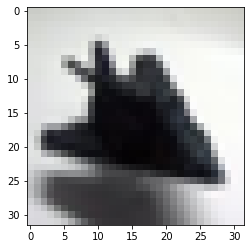

In [21]:
show_example(*dataset[0])
print(len(dataset))

In [22]:
# Splitting the data into training and validation sets
from torch.utils.data import random_split
train_data, val_data = random_split(dataset, [40000, 10000])

In [23]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [60]:
# Converting data into batches for training and validation
from torch.utils.data import DataLoader
batch_size = 1000
train_loader = DataLoader(train_data,batch_size, shuffle = True)
# Shuffle set to true to get different batch of data every epoch
val_loader = DataLoader(val_data, batch_size)

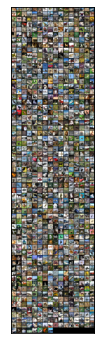

In [61]:
show_batch(train_loader)

In [69]:
# Defining model 
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # 3 = number of input channels and 32 = no. of output channels
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # loutput: 64 x 16 x 16

#     nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

#     nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

    nn.Flatten(), 
#     nn.Linear(128*8*8, 10),
#     nn.ReLU(),
#     nn.Linear(1024, 512),
#     nn.ReLU(),
    nn.Linear(64*16*16, 10))



In [70]:
loss_fn = torch.nn.functional.cross_entropy

def fit(epochs, lr):
    
    opt = torch.optim.Adam(model.parameters(), lr)
    da = []
    
    for epoch in range(epochs):
        a = []
        i = 0
        model.train()
        for image, label in train_loader:
            out = model(image)
            loss = loss_fn(out, label)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()  
        for image, label in val_loader:
            out = model(image)
            _,pred = torch.max(out,1)
            acc = (torch.sum(pred==label)/len(label))
            a.append(acc)
            i+=1
        da.append(sum(a)/i)
        print(sum(a)/i)
            
            
    

In [71]:
fit(5, 0.05)

tensor(0.2822)
tensor(0.1999)
tensor(0.3734)
tensor(0.4038)
tensor(0.4301)


In [ ]:
 for image, label in val_loader:
            out = model(image)
            print(out)
            _,pred = torch.max(out, 1)
            print(pred)
            print(torch.sum(pred == label)/len(pred))
            break